# Data Preparation for EMNIST Letters Dataset

## Load the Dataset

In [29]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
data = pd.read_csv('../emnist-letters-train.csv')

# Check the shape and first few rows
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (64828, 785)


,24,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.552,0.553,0.554,0.555,0.556,0.557,0.558,0.559,0.560,0.561
0,-2,142,142,142,142,142,142,142,142,142,...,142,142,142,142,142,142,142,142,142,142
1,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,14,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-2,120,120,120,120,120,120,120,120,120,...,120,120,120,120,120,120,120,120,120,120
4,-1,131,131,131,131,131,131,131,131,200,...,131,131,131,131,131,131,131,131,131,131


## Understanding the Data Structure

Unique labels: [-2 -1  1  2  4  5  6  7  9 10 12 14 15 16 17 20 24 26]


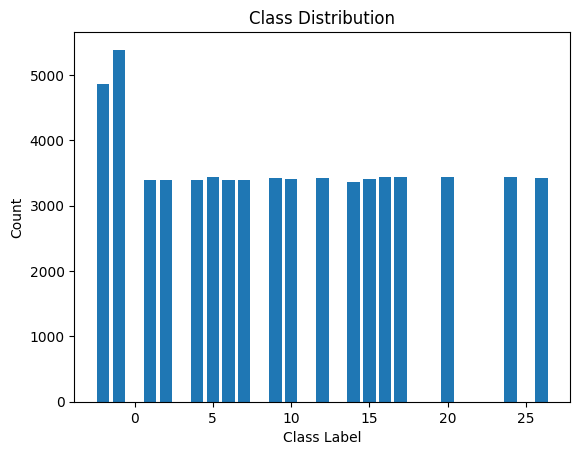

Unique labels before cleaning: [-2 -1  1  2  4  5  6  7  9 10 12 14 15 16 17 20 24 26]
Label counts before cleaning: [4856 5384 3396 3396 3398 3437 3394 3385 3428 3402 3415 3365 3408 3430
 3435 3436 3436 3427]
Total images before cleaning: 64828
Corresponding letters: ['>', '?', 'A', 'B', 'D', 'E', 'F', 'G', 'I', 'J', 'L', 'N', 'O', 'P', 'Q', 'T', 'X', 'Z']


In [30]:
# Separate labels and pixel data
labels = data.iloc[:, 0].values
pixels = data.iloc[:, 1:].values

# Check label distribution
unique_labels, counts = np.unique(labels, return_counts=True)
print(f"Unique labels: {unique_labels}")

# Visualize class distribution
plt.bar(unique_labels, counts)
plt.title('Class Distribution')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.show()

print(f"Unique labels before cleaning: {unique_labels}")
print(f"Label counts before cleaning: {counts}")
print(f"Total images before cleaning: {len(pixels)}")
print(f"Corresponding letters: {[chr(l+64) for l in unique_labels]}")

In [31]:
# Reshape and normalize
images = pixels.reshape(-1, 28, 28, 1).astype('float32')
images = (images - 127.5) / 127.5  # Normalize to [-1, 1]

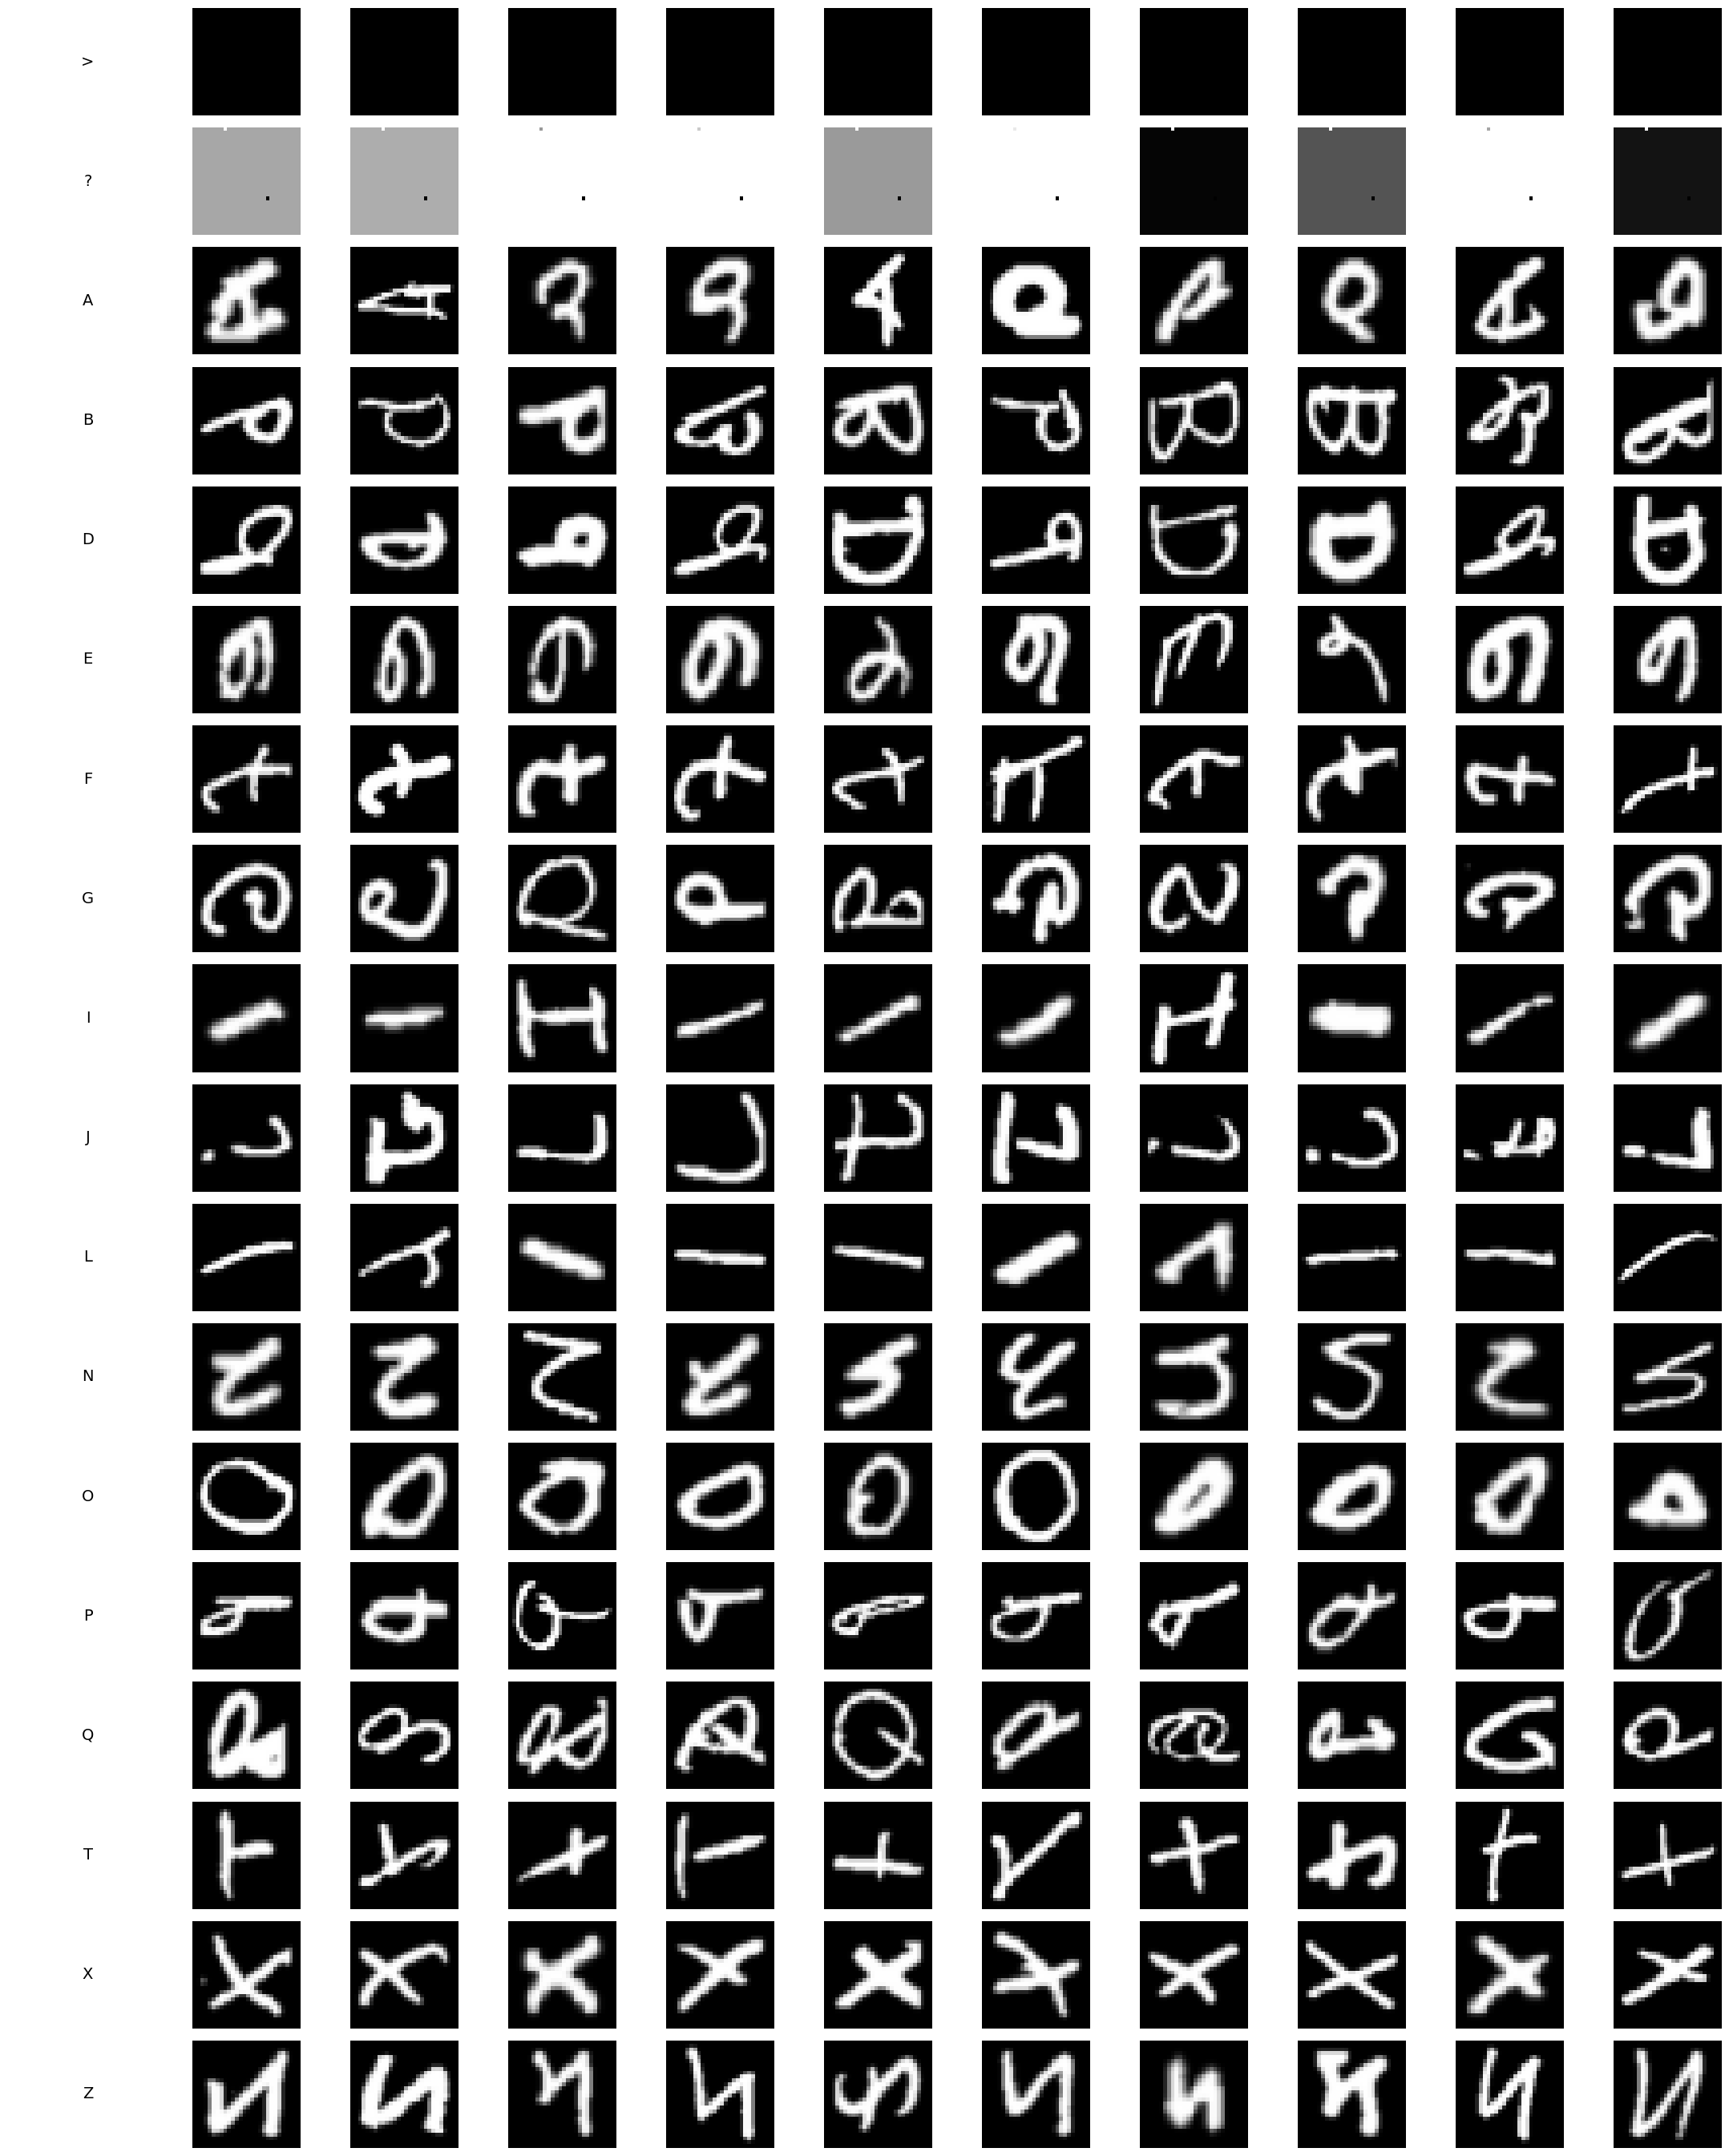

In [32]:
# Get all unique class labels
unique_labels_to_show = np.sort(np.unique(labels))
num_classes = len(unique_labels_to_show)

# Set number of columns and compute required rows dynamically
cols = 11  # 1 for label + 10 for sample images
rows = math.ceil(num_classes / 1)  # Each class gets its own row

plt.figure(figsize=(cols * 2, rows * 1.5))  # Adjust figure size

for idx, class_label in enumerate(unique_labels_to_show):
  class_indices = np.nonzero(labels == class_label)[0][:10]  # Get 10 samples

  # Label subplot
  plt.subplot(rows, cols, idx * cols + 1)
  plt.text(0.5, 0.5, f"{chr(class_label + 64)}", fontsize=14, ha='center', va='center')
  plt.axis('off')

  # Show 10 example images
  for i, img_idx in enumerate(class_indices):
    plt.subplot(rows, cols, idx * cols + i + 2)
    plt.imshow(images[img_idx].squeeze(), cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()


## Data Cleaning

In [33]:
# First filter out negative labels
valid_mask = labels > 0
filtered_images = images[valid_mask]
filtered_labels = labels[valid_mask]

# Then select only our 16 target classes
selected_numeric = [1, 2, 4, 5, 6, 7, 9, 10, 12, 14, 15, 16, 17, 20, 24, 26]  # A, B, D, E, F, G, I, J, L, N, O, P, Q, T, X, Z
final_mask = np.isin(filtered_labels, selected_numeric)
final_images = filtered_images[final_mask]
final_labels = filtered_labels[final_mask]

In [34]:
# Rotate and flip the images to upright position
from skimage.transform import rotate

# Rotate 90 degrees clockwise (use -90 degrees)
# Then mirror (flip) horizontally with np.fliplr
final_images = np.array([
    np.fliplr(rotate(img.squeeze(), -90, resize=False, mode='edge'))
    for img in final_images
])

# Ensure final_images has the correct shape
final_images = final_images[..., np.newaxis]

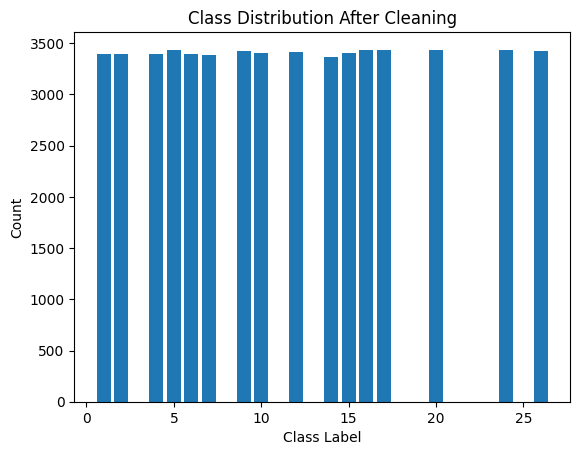

Unique labels after cleaning: [ 1  2  4  5  6  7  9 10 12 14 15 16 17 20 24 26]
Label counts after cleaning: [3396 3396 3398 3437 3394 3385 3428 3402 3415 3365 3408 3430 3435 3436
 3436 3427]
Total images after cleaning: 54588
Corresponding letters: ['A', 'B', 'D', 'E', 'F', 'G', 'I', 'J', 'L', 'N', 'O', 'P', 'Q', 'T', 'X', 'Z']


In [35]:
# Show class distribution after cleaning
unique_labels_cleaned, counts_cleaned = np.unique(final_labels, return_counts=True)
plt.bar(unique_labels_cleaned, counts_cleaned)
plt.title('Class Distribution After Cleaning')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.show()

print(f"Unique labels after cleaning: {unique_labels_cleaned}")
print(f"Label counts after cleaning: {counts_cleaned}")
print(f"Total images after cleaning: {len(final_images)}")
print(f"Corresponding letters: {[chr(l+64) for l in unique_labels_cleaned]}")


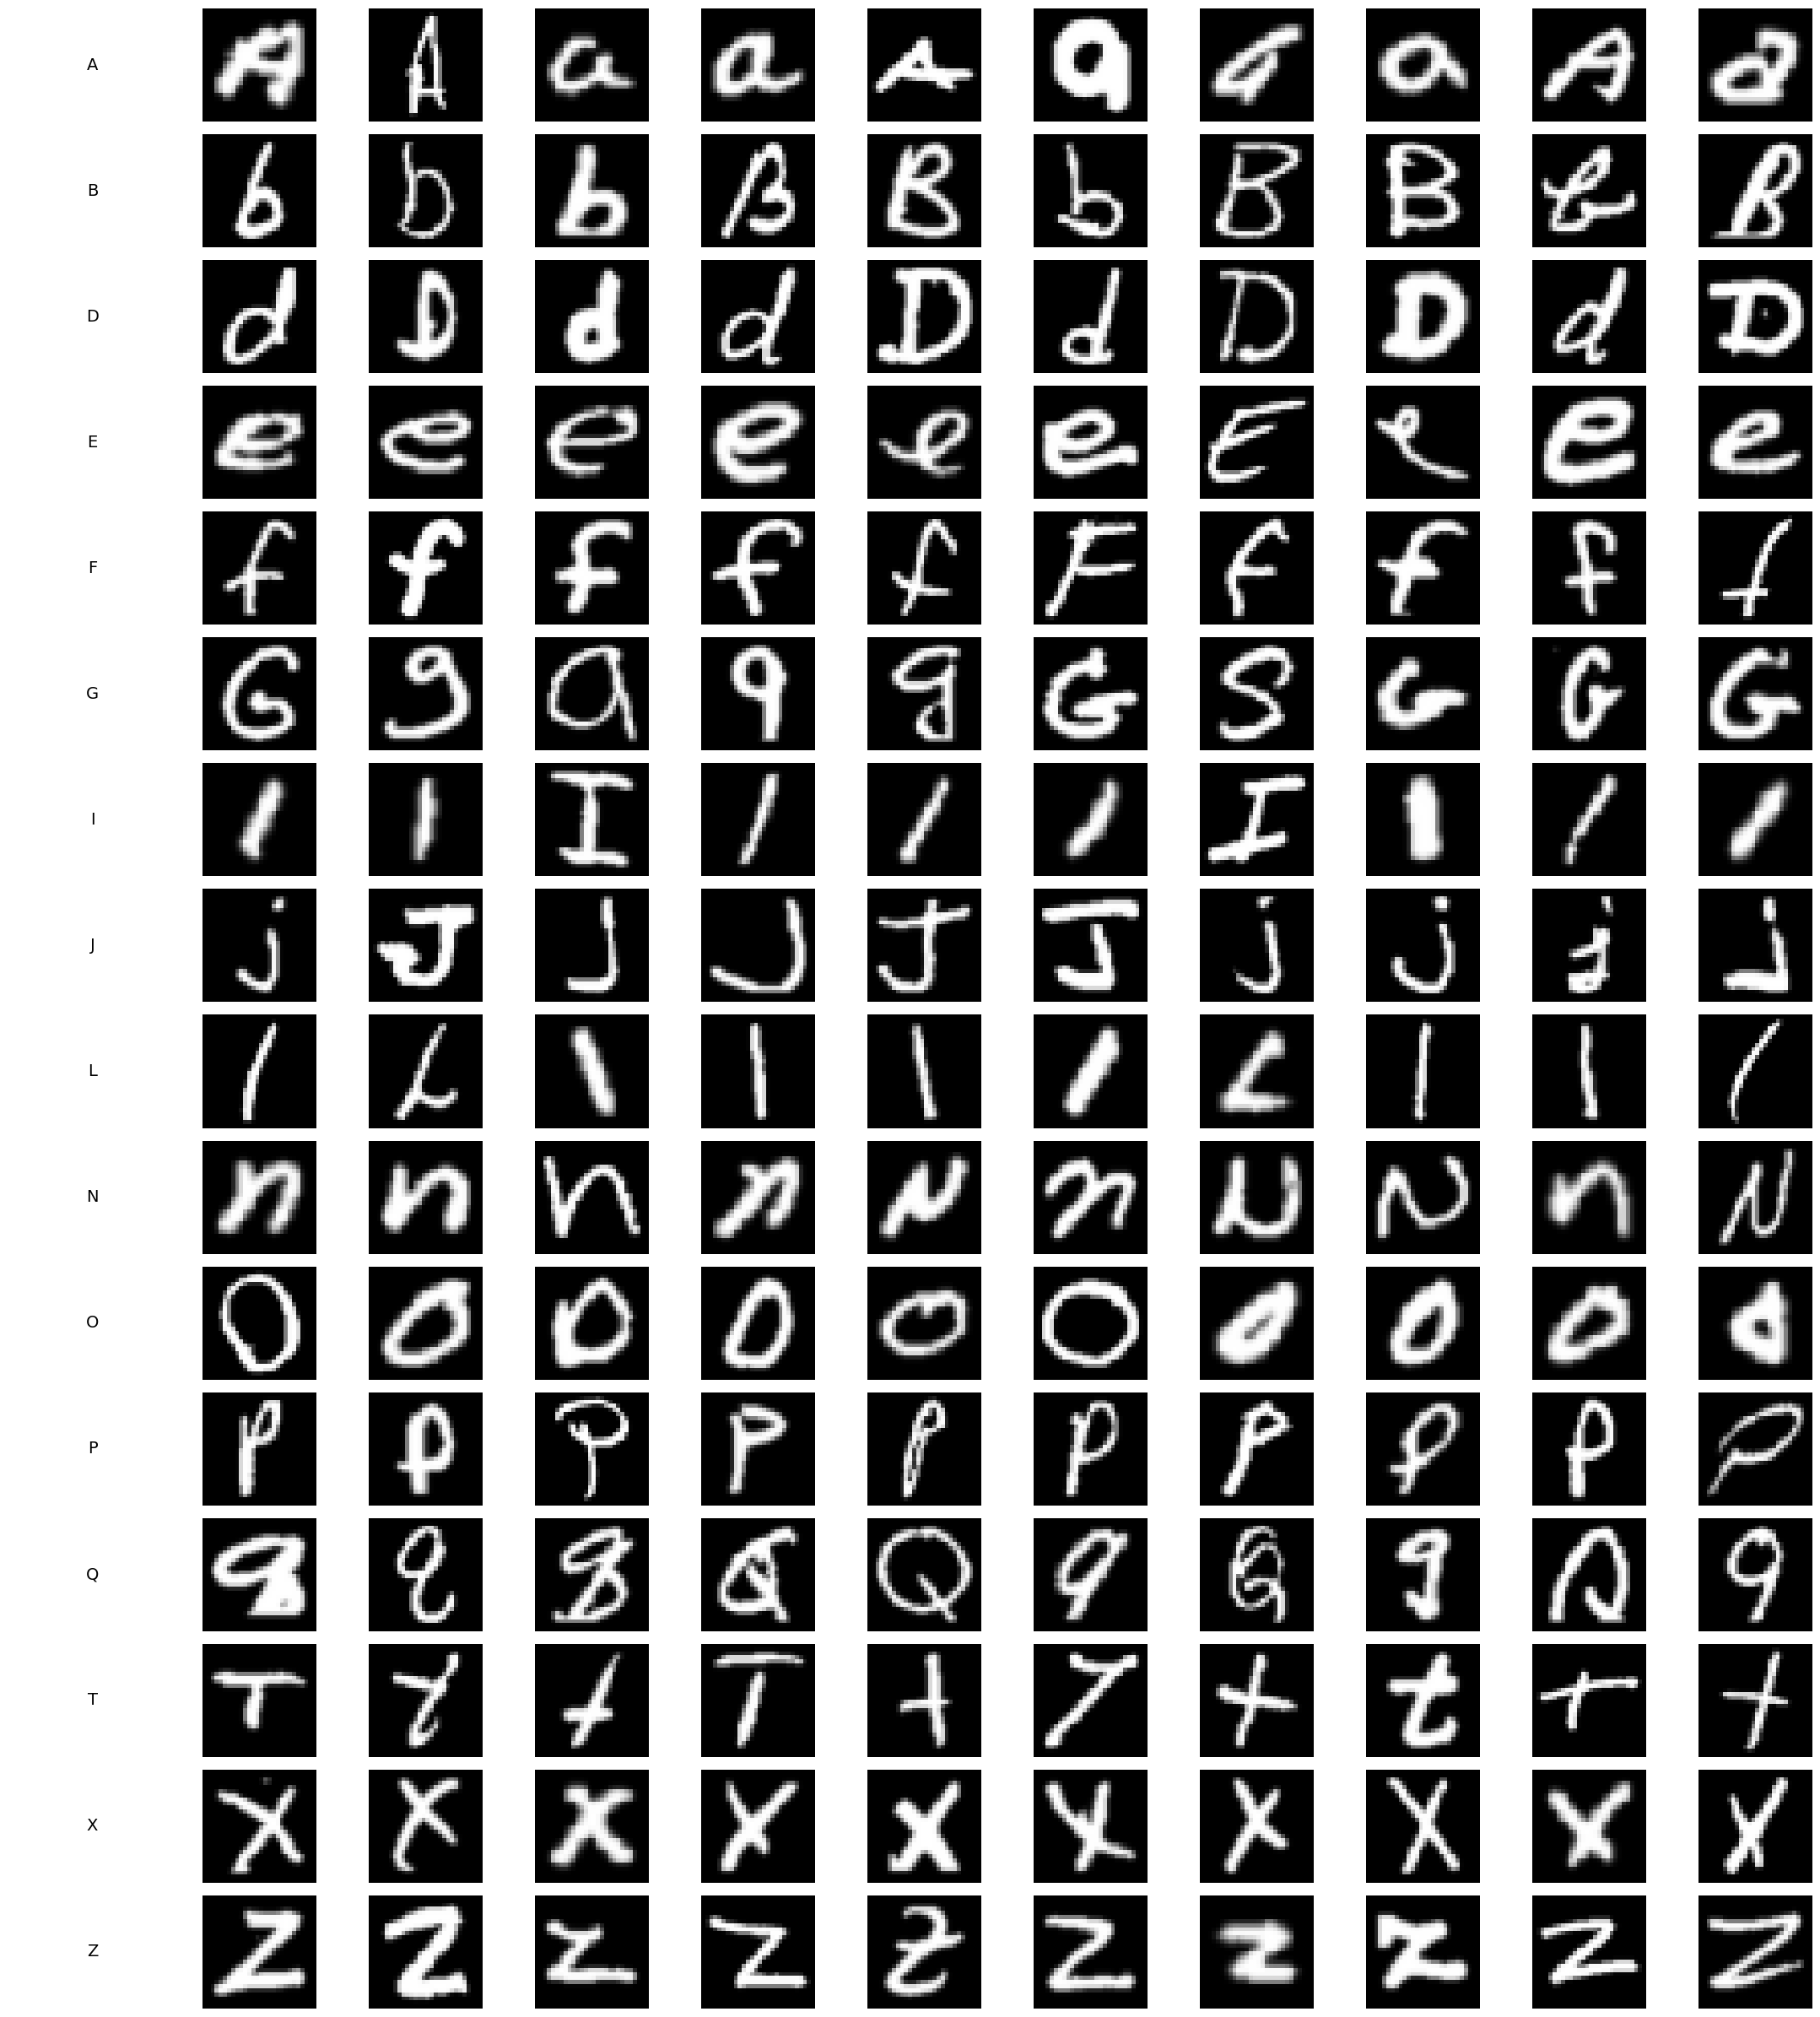

In [36]:
# Get all unique class labels from cleaned data
unique_labels_to_show = np.sort(np.unique(final_labels))
num_classes = len(unique_labels_to_show)

# Set number of columns and compute required rows dynamically
cols = 11  # 1 for label + 10 for sample images
rows = math.ceil(num_classes / 1)  # Each class gets its own row

plt.figure(figsize=(cols * 2, rows * 1.5))  # Adjust figure size

for idx, class_label in enumerate(unique_labels_to_show):
  class_indices = np.nonzero(final_labels == class_label)[0][:10]  # Get 10 samples

  # Label subplot
  plt.subplot(rows, cols, idx * cols + 1)
  plt.text(0.5, 0.5, f"{chr(class_label + 64)}", fontsize=14, ha='center', va='center')
  plt.axis('off')

  # Show 10 example images
  for i, img_idx in enumerate(class_indices):
    plt.subplot(rows, cols, idx * cols + i + 2)
    plt.imshow(final_images[img_idx].squeeze(), cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()


## Preparing for Conditional GAN

In [37]:
from tensorflow.keras.utils import to_categorical

# Convert labels to one-hot encoding (for 16 classes)
selected_letters = ['A', 'B', 'D', 'E', 'F', 'G', 'I', 'J', 'L', 'N', 'O', 'P', 'Q', 'T', 'X', 'Z']

# Convert letters to their label values (A=1, B=2, ..., Z=26)
selected_labels = [ord(c) - 64 for c in selected_letters]

# Now convert to 0-15 range for one-hot encoding
label_mapping = {label: idx for idx, label in enumerate(selected_labels)}
mapped_labels = np.array([label_mapping[label] for label in filtered_labels])

# One-hot encode (now safe with 16 classes)
one_hot_labels = to_categorical(mapped_labels, num_classes=16)

In [38]:
integer_labels = np.argmax(one_hot_labels, axis=1)
labels = integer_labels[idx].reshape(-1, 1)

## Data Verification 

In [39]:
# Check Basic Shapes & Types
print("Total samples:", len(final_images))
print("Image shape:", final_images.shape[1:])
print("Labels shape:", one_hot_labels.shape)
print("Image dtype:", final_images.dtype)
print("Label dtype:", one_hot_labels.dtype)


Total samples: 54588
Image shape: (28, 28, 1)
Labels shape: (54588, 16)
Image dtype: float32
Label dtype: float32


In [40]:
# Check pixel value range
print("Pixel value range:", final_images.min(), "to", final_images.max())

Pixel value range: -1.0 to 1.0


In [41]:
# Check label classes and distribution
# If labels are one-hot encoded, convert back to class indices
labels_int = np.argmax(one_hot_labels, axis=1)

print("Label classes in dataset:", np.unique(labels_int))
print("Label distribution:")
unique, counts = np.unique(labels_int, return_counts=True)
print(dict(zip(unique, counts)))


Label classes in dataset: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Label distribution:
{0: 3396, 1: 3396, 2: 3398, 3: 3437, 4: 3394, 5: 3385, 6: 3428, 7: 3402, 8: 3415, 9: 3365, 10: 3408, 11: 3430, 12: 3435, 13: 3436, 14: 3436, 15: 3427}


In [42]:
print("Labels shape:", labels.shape)
print("Labels example:", labels[0])

# Check if labels look like one-hot vectors
if len(labels.shape) == 2 and labels.shape[1] > 1:
    print("Likely one-hot encoded")
elif len(labels.shape) == 1 or (len(labels.shape) == 2 and labels.shape[1] == 1):
    print("Likely integer labels")
else:
    print("Unknown label format")


Labels shape: (1, 1)
Labels example: [12]
Likely integer labels


In [43]:
print("Labels shape:", mapped_labels.shape)
print("Labels example:", mapped_labels[0])

# Check if labels look like one-hot vectors
if len(mapped_labels.shape) == 2 and mapped_labels.shape[1] > 1:
    print("Likely one-hot encoded")
elif len(mapped_labels.shape) == 1 or (len(labels.shape) == 2 and labels.shape[1] == 1):
    print("Likely integer labels")
else:
    print("Unknown label format")

Labels shape: (54588,)
Labels example: 10
Likely integer labels


# Base Model

## Model Building

In [26]:
def build_generator(latent_dim=100, num_classes=16):
    # Conditional input
    label_input = layers.Input(shape=(1,))
    label_embedding = layers.Embedding(num_classes, 50)(label_input)
    label_embedding = layers.Flatten()(label_embedding)
    
    # Noise input
    noise_input = layers.Input(shape=(latent_dim,))
    
    # Combined input
    combined = layers.Concatenate()([noise_input, label_embedding])
    
    # Generator network
    x = layers.Dense(7*7*256, use_bias=False)(combined)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    
    x = layers.Reshape((7, 7, 256))(x)
    
    x = layers.Conv2DTranspose(128, (5,5), strides=(1,1), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    
    x = layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    
    x = layers.Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh')(x)
    
    return models.Model([noise_input, label_input], x, name='generator')

def build_discriminator(img_shape=(28,28,1), num_classes=16):
    # Image input
    img_input = layers.Input(shape=img_shape)
    
    # Label input
    label_input = layers.Input(shape=(1,))
    label_embedding = layers.Embedding(num_classes, 50)(label_input)
    label_embedding = layers.Flatten()(label_embedding)
    label_embedding = layers.Dense(np.prod(img_shape))(label_embedding)
    label_embedding = layers.Reshape(img_shape)(label_embedding)
    
    # Combined input
    combined = layers.Concatenate()([img_input, label_embedding])
    
    # Discriminator network
    x = layers.Conv2D(64, (5,5), strides=(2,2), padding='same')(combined)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Conv2D(128, (5,5), strides=(2,2), padding='same')(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(1, activation='sigmoid')(x)
    
    return models.Model([img_input, label_input], x, name='discriminator')

# Build and compile
latent_dim = 100
img_shape = (28,28,1)
num_classes = 16

generator = build_generator(latent_dim, num_classes)
discriminator = build_discriminator(img_shape, num_classes)

discriminator.compile(
    optimizer=optimizers.Adam(0.0002, 0.5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Combined GAN
discriminator.trainable = False
noise = layers.Input(shape=(latent_dim,))
label = layers.Input(shape=(1,))
img = generator([noise, label])
validity = discriminator([img, label])
gan = models.Model([noise, label], validity)
gan.compile(
    optimizer=optimizers.Adam(0.0002, 0.5),
    loss='binary_crossentropy'
)

## Model Training

In [27]:
def train_gan(epochs, batch_size=128, sample_interval=50, X_train=None, y_train=None, save_dir=None):
    # Load and normalize data
    X_train, y_train = X_train, y_train  # From your data prep
    
    # Adversarial ground truths
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    
    for epoch in range(epochs):
        # Train discriminator
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs, labels = X_train[idx], y_train[idx]
        
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        gen_labels = np.random.randint(0, num_classes, batch_size)
        gen_imgs = generator.predict([noise, gen_labels.reshape(-1,1)], verbose=0)
        
        d_loss_real = discriminator.train_on_batch([imgs, labels.reshape(-1,1)], valid)
        d_loss_fake = discriminator.train_on_batch([gen_imgs, gen_labels.reshape(-1,1)], fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        # Train generator
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        valid_labels = np.random.randint(0, num_classes, batch_size)
        g_loss = gan.train_on_batch([noise, valid_labels.reshape(-1,1)], valid)
        
        # Print progress
        if epoch % sample_interval == 0:
            print(f"{epoch} [D loss: {d_loss[0]:.4f}, acc.: {100*d_loss[1]:.2f}%] [G loss: {g_loss:.4f}]")
            sample_images(epoch, save_dir=save_dir)
    
    # Save weights
    generator.save_weights('base_generator.weights.h5')
    discriminator.save_weights('base_discriminator.weights.h5')

def sample_images(epoch, save_dir=None):
  num_samples = 3  # Only 3 samples per class
  num_classes = len(selected_letters)
  nrows = num_samples + 1  # 1 for label, rest for images
  ncols = num_classes

  fig, axs = plt.subplots(nrows, ncols, figsize=(2 * ncols, 2 * nrows))

  noise = np.random.normal(0, 1, (num_classes * num_samples, latent_dim))
  sampled_labels = np.repeat(np.arange(num_classes), num_samples).reshape(-1, 1)
  gen_imgs = generator.predict([noise, sampled_labels], verbose=0)
  gen_imgs = 0.5 * gen_imgs + 0.5  # Rescale to [0,1]

  for class_idx in range(num_classes):
    # First row: show label
    axs[0, class_idx].text(0.5, 0.5, selected_letters[class_idx], fontsize=16, ha='center', va='center')
    axs[0, class_idx].set_xticks([])
    axs[0, class_idx].set_yticks([])
    axs[0, class_idx].set_frame_on(False)

    # Next rows: show generated images
    for sample_idx in range(num_samples):
      img_idx = class_idx * num_samples + sample_idx
      axs[sample_idx + 1, class_idx].imshow(gen_imgs[img_idx, :, :, 0], cmap='gray', aspect='equal')
      axs[sample_idx + 1, class_idx].set_xticks([])
      axs[sample_idx + 1, class_idx].set_yticks([])
      axs[sample_idx + 1, class_idx].set_frame_on(False)

  plt.tight_layout(pad=0.2)
  os.makedirs(save_dir, exist_ok=True)
  plt.savefig(f"{save_dir}/epoch_{epoch}.png", bbox_inches='tight', dpi=120, pad_inches=0.01)
  plt.close()


In [ ]:
# Train the model
train_gan(epochs=5001, batch_size=64, sample_interval=100, X_train=final_images, y_train=mapped_labels, save_dir="base_images_samples")

0 [D loss: 0.6909, acc.: 25.78%] [G loss: 0.6482]
100 [D loss: 0.0715, acc.: 98.44%] [G loss: 0.0010]
200 [D loss: 0.0056, acc.: 100.00%] [G loss: 0.0000]
300 [D loss: 0.0120, acc.: 99.22%] [G loss: 0.0003]
400 [D loss: 0.0042, acc.: 100.00%] [G loss: 0.0010]
500 [D loss: 0.0087, acc.: 100.00%] [G loss: 0.0005]
600 [D loss: 0.0668, acc.: 99.22%] [G loss: 0.5457]
700 [D loss: 0.8648, acc.: 58.59%] [G loss: 0.3316]
800 [D loss: 0.6559, acc.: 62.50%] [G loss: 0.9134]
900 [D loss: 0.7346, acc.: 50.00%] [G loss: 0.7172]
1000 [D loss: 0.6611, acc.: 57.81%] [G loss: 0.7491]
1100 [D loss: 0.7000, acc.: 50.78%] [G loss: 0.8032]
1200 [D loss: 0.6239, acc.: 67.19%] [G loss: 0.8214]
1300 [D loss: 0.6560, acc.: 61.72%] [G loss: 0.7482]
1400 [D loss: 0.7073, acc.: 46.88%] [G loss: 0.7651]
1500 [D loss: 0.6581, acc.: 59.38%] [G loss: 0.7793]
1600 [D loss: 0.6874, acc.: 53.91%] [G loss: 0.7753]
1700 [D loss: 0.6907, acc.: 52.34%] [G loss: 0.7773]
1800 [D loss: 0.7382, acc.: 42.19%] [G loss: 0.7145]
19

# Re-import data

In [44]:
from tensorflow.keras.models import load_model

model = load_model('./EMNIST Classifier/emnist_letter_classifier.h5')

In [45]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
data = pd.read_csv("C:\School\Year 2\DELE\CA2\emnist-letters-train.csv")

# Check the shape and first few rows
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (64828, 785)


,24,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.552,0.553,0.554,0.555,0.556,0.557,0.558,0.559,0.560,0.561
0,-2,142,142,142,142,142,142,142,142,142,...,142,142,142,142,142,142,142,142,142,142
1,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,14,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-2,120,120,120,120,120,120,120,120,120,...,120,120,120,120,120,120,120,120,120,120
4,-1,131,131,131,131,131,131,131,131,200,...,131,131,131,131,131,131,131,131,131,131


In [46]:
# Separate labels and pixel data
labels = data.iloc[:, 0].values
pixels = data.iloc[:, 1:].values

# Reshape and normalize to match training data
images = pixels.reshape(-1, 28, 28, 1).astype('float32')
images = images / 255.0  # Normalize to [0, 1] - SAME AS TRAINING DATA

# First filter out negative labels
valid_mask = labels > 0
filtered_images = images[valid_mask]
filtered_labels = labels[valid_mask]

# Then select only our 16 target classes
selected_numeric = [1, 2, 4, 5, 6, 7, 9, 10, 12, 14, 15, 16, 17, 20, 24, 26]  # A, B, D, E, F, G, I, J, L, N, O, P, Q, T, X, Z
final_mask = np.isin(filtered_labels, selected_numeric)
final_images = filtered_images[final_mask]
final_labels = filtered_labels[final_mask]

In [47]:
# Rotate and flip the images to upright position
from skimage.transform import rotate

# Rotate 90 degrees clockwise (use -90 degrees)
# Then mirror (flip) horizontally with np.fliplr
rotated_images = np.array([
    np.fliplr(rotate(img.squeeze(), -90, resize=False, mode='edge'))
    for img in final_images
])

# Ensure final_images has the correct shape
final_images = rotated_images[..., np.newaxis]

# CRITICAL: Re-normalize to [0, 1] to match training data
# The rotation operation may have changed the pixel range
final_images = final_images.astype('float32')
final_images = (final_images - final_images.min()) / (final_images.max() - final_images.min())

print(f"After processing - pixel range: [{final_images.min():.3f}, {final_images.max():.3f}]")

After processing - pixel range: [0.000, 1.000]


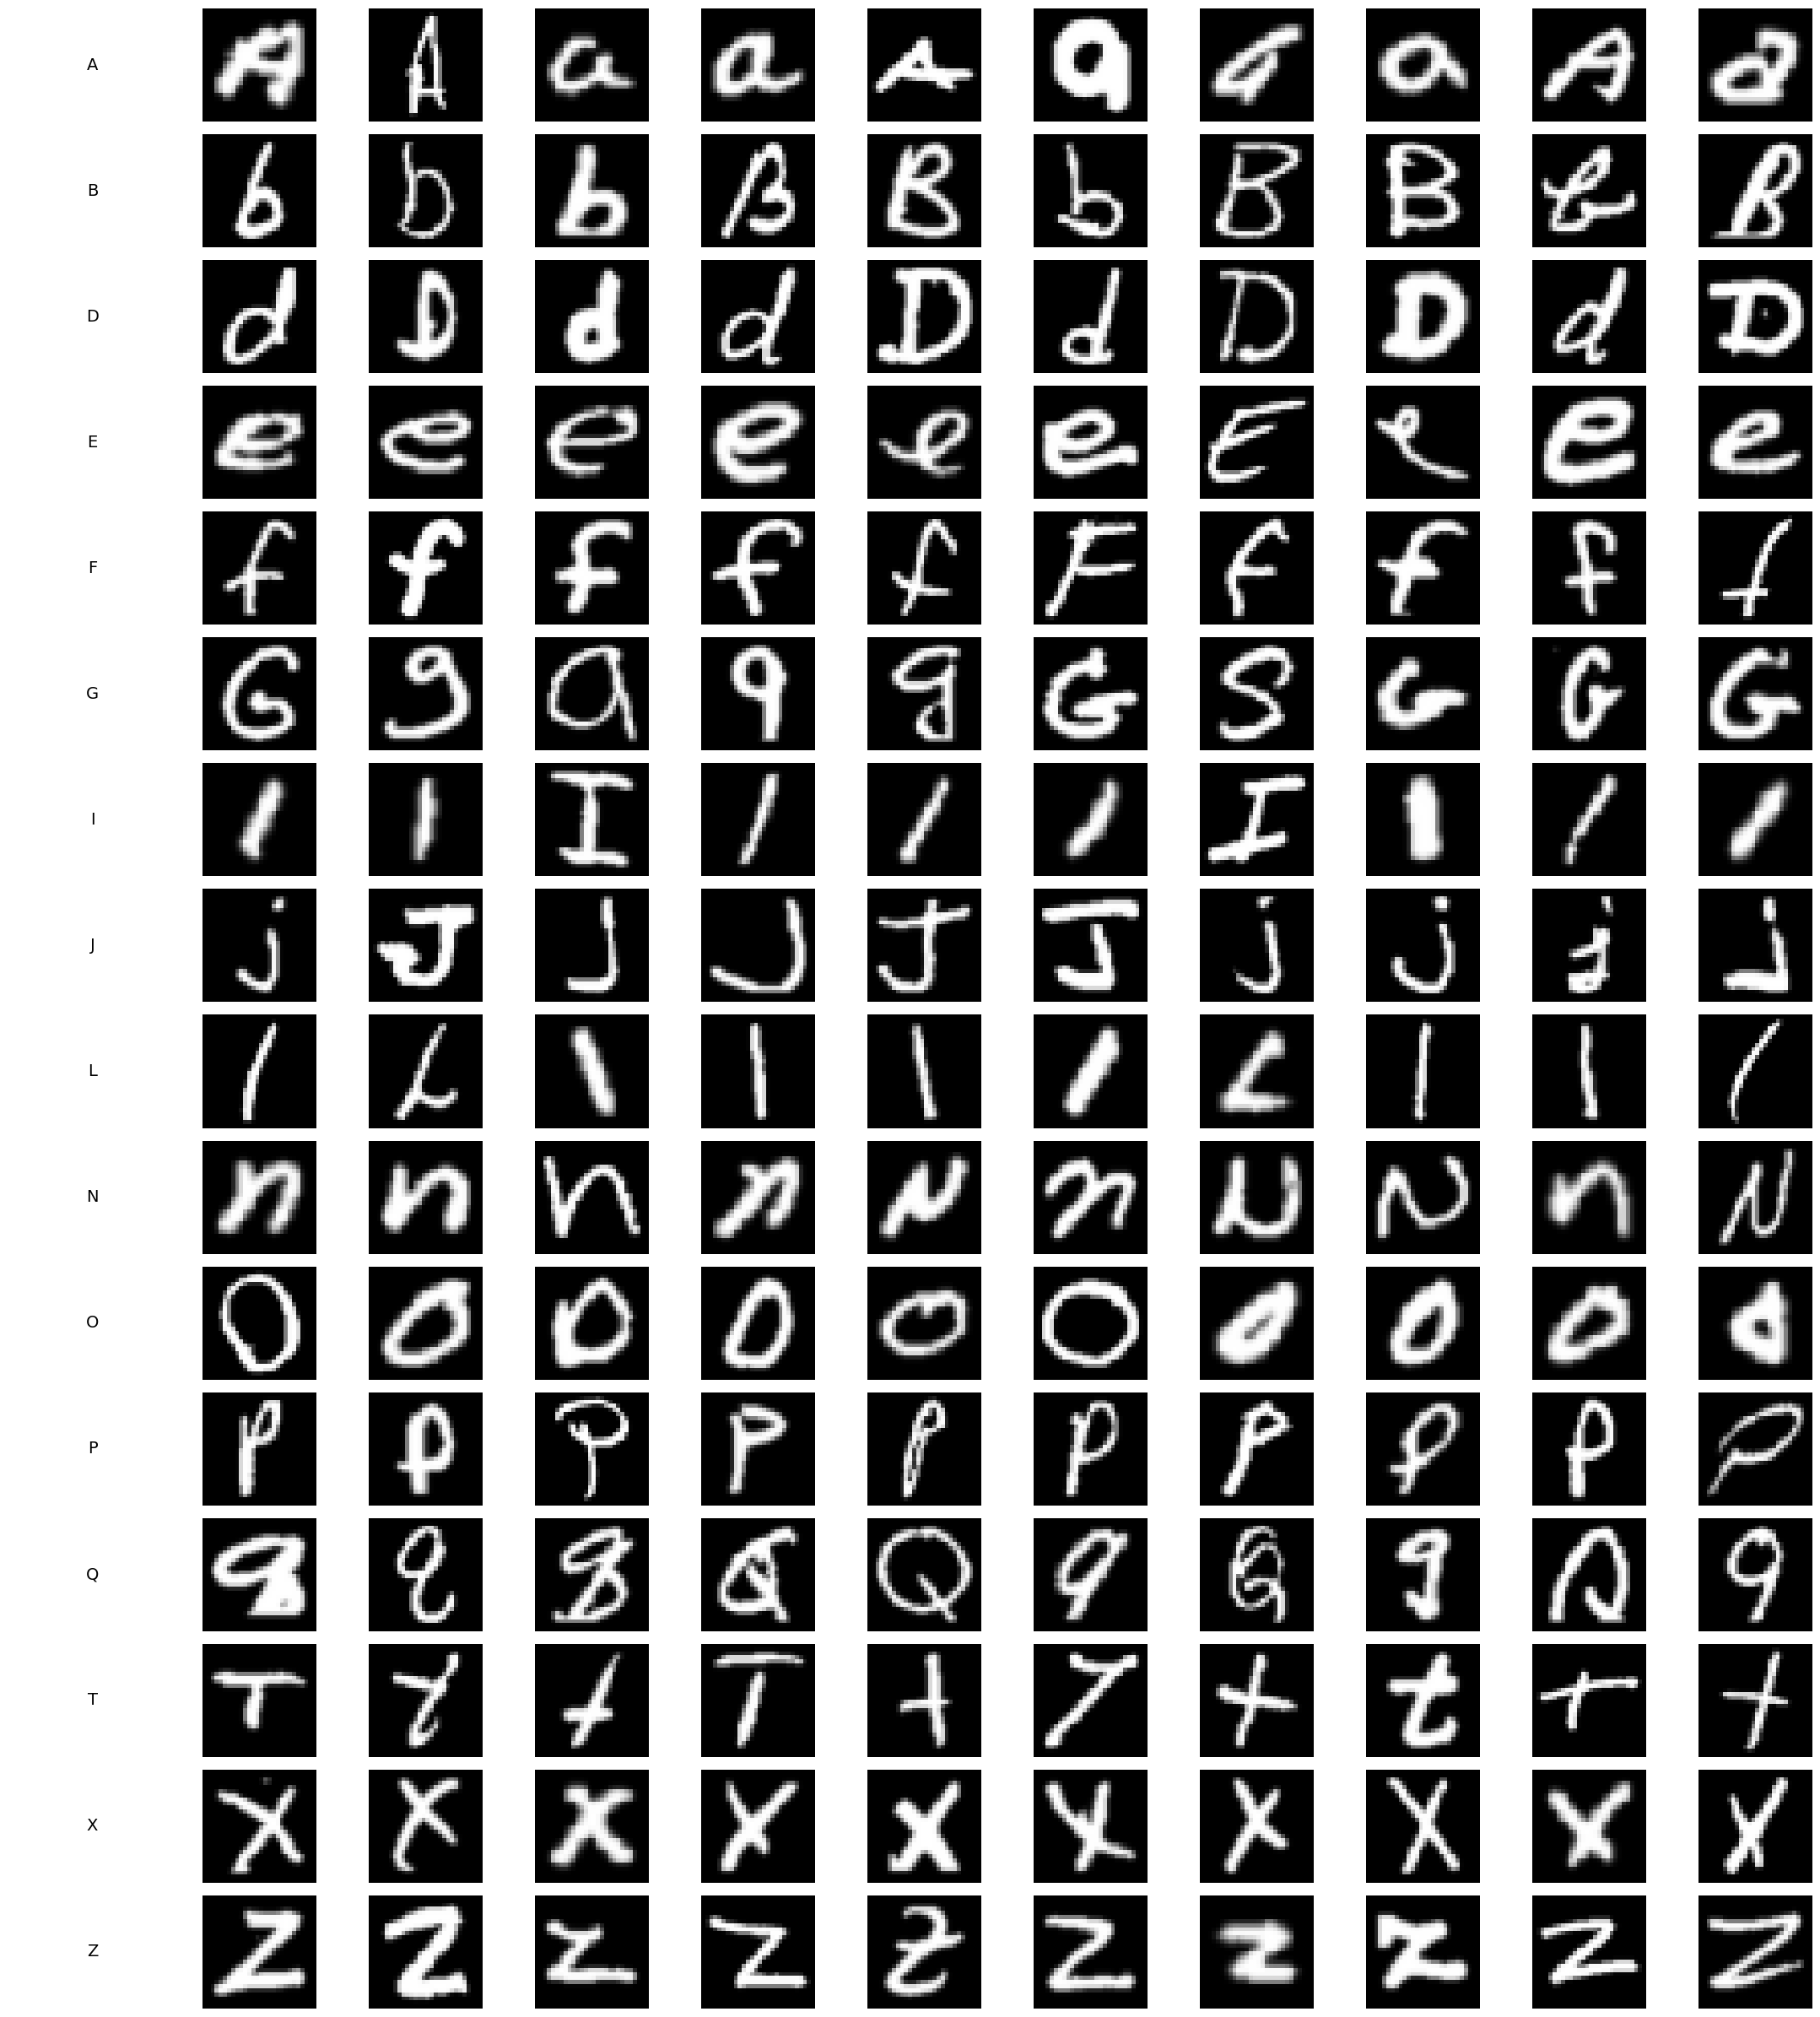

In [48]:
# Get all unique class labels from cleaned data
unique_labels_to_show = np.sort(np.unique(final_labels))
num_classes = len(unique_labels_to_show)

# Set number of columns and compute required rows dynamically
cols = 11  # 1 for label + 10 for sample images
rows = math.ceil(num_classes / 1)  # Each class gets its own row

plt.figure(figsize=(cols * 2, rows * 1.5))  # Adjust figure size

for idx, class_label in enumerate(unique_labels_to_show):
  class_indices = np.nonzero(final_labels == class_label)[0][:10]  # Get 10 samples

  # Label subplot
  plt.subplot(rows, cols, idx * cols + 1)
  plt.text(0.5, 0.5, f"{chr(class_label + 64)}", fontsize=14, ha='center', va='center')
  plt.axis('off')

  # Show 10 example images
  for i, img_idx in enumerate(class_indices):
    plt.subplot(rows, cols, idx * cols + i + 2)
    plt.imshow(final_images[img_idx].squeeze(), cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [49]:
# Predict letters for all images in final_images using the trained model
pred_probs = model.predict(final_images, batch_size=128, verbose=1)
predicted_labels = np.argmax(pred_probs, axis=1)

# Map numeric labels to characters using the SAME mapping as training
# Training uses: 0-25 for A-Z, 26-51 for a-z
def model_label_to_char(label):
    if label < 26:
        return chr(label + ord('A'))  # 0='A', 1='B', ..., 25='Z'
    else:
        return chr(label - 26 + ord('a'))  # 26='a', 27='b', ..., 51='z'

# Map EMNIST CSV labels to characters (for ground truth)
def csv_label_to_char(label):
    return chr(label + 64)  # EMNIST Letters: 1='A', 2='B', ..., 26='Z'

# Example: show predictions for the first 10 samples
for i in range(10):
    true_char = csv_label_to_char(final_labels[i])
    pred_char = model_label_to_char(predicted_labels[i])
    confidence = np.max(pred_probs[i])
    print(f"Sample {i+1}: True: {true_char} | Predicted: {pred_char} (confidence: {confidence:.3f})")

427/427 [==============================] - 3s 7ms/step
Sample 1: True: O | Predicted: O (confidence: 0.970)
Sample 2: True: N | Predicted: n (confidence: 1.000)
Sample 3: True: A | Predicted: A (confidence: 0.990)
Sample 4: True: J | Predicted: j (confidence: 1.000)
Sample 5: True: E | Predicted: e (confidence: 1.000)
Sample 6: True: G | Predicted: G (confidence: 0.998)
Sample 7: True: G | Predicted: g (confidence: 0.997)
Sample 8: True: F | Predicted: f (confidence: 0.568)
Sample 9: True: O | Predicted: O (confidence: 0.921)
Sample 10: True: F | Predicted: F (confidence: 0.854)


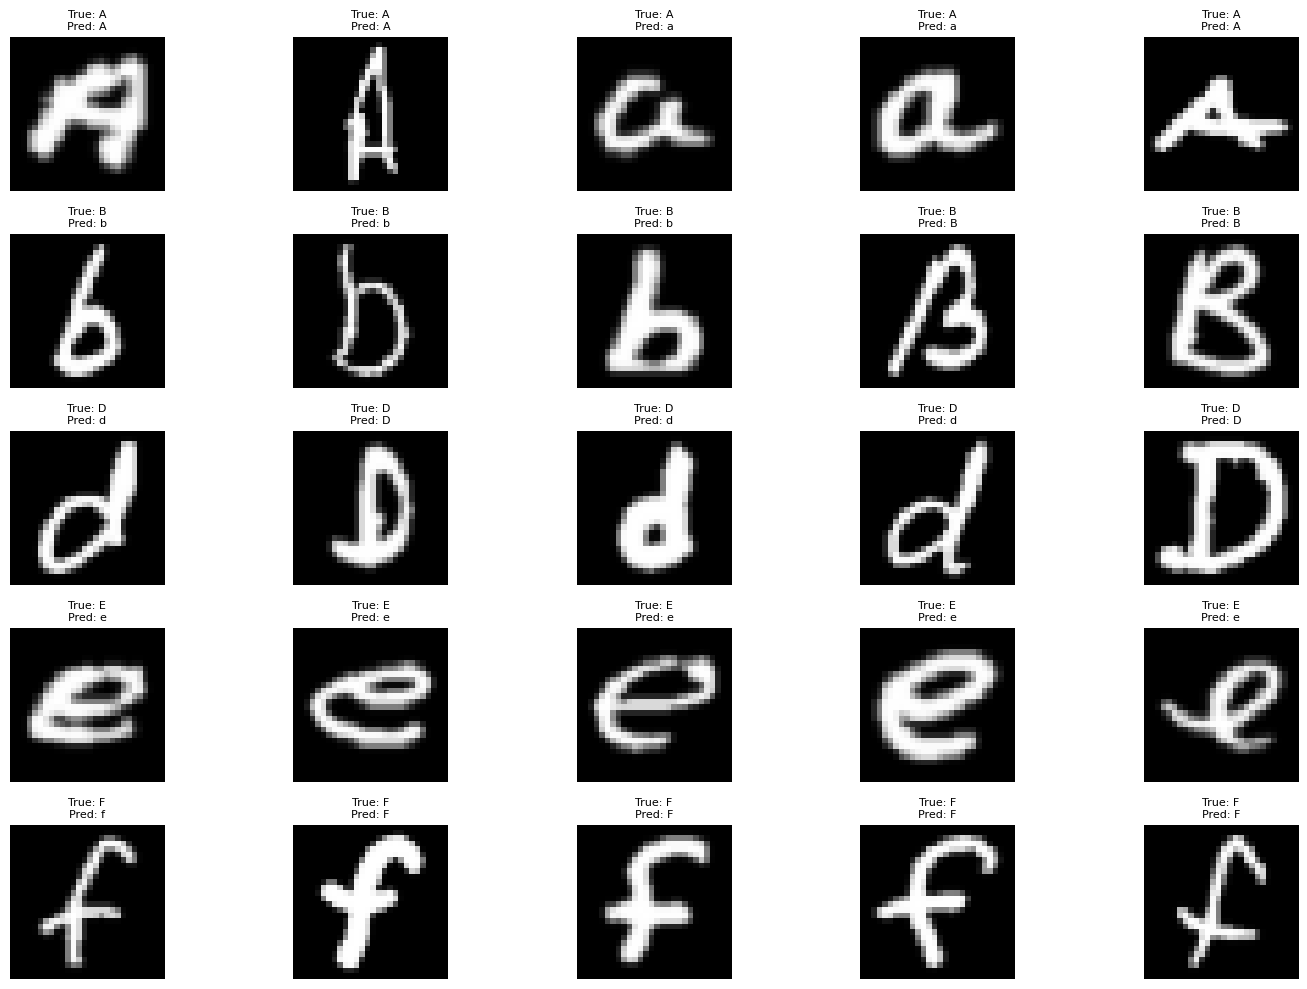

Image pixel range: [0.000, 1.000]
Image shape: (54588, 28, 28, 1)
Image dtype: float32


In [50]:
# Let's visualize some samples to check if the preprocessing is correct
plt.figure(figsize=(15, 10))

# Show first 5 samples of each class
sample_classes = [1, 2, 4, 5, 6]  # A, B, D, E, F
for i, class_label in enumerate(sample_classes):
    class_indices = np.where(final_labels == class_label)[0][:5]
    
    for j, idx in enumerate(class_indices):
        plt.subplot(len(sample_classes), 5, i * 5 + j + 1)
        plt.imshow(final_images[idx].squeeze(), cmap='gray')
        true_char = csv_label_to_char(final_labels[idx])
        pred_char = model_label_to_char(predicted_labels[idx])
        plt.title(f'True: {true_char}\nPred: {pred_char}', fontsize=8)
        plt.axis('off')

plt.tight_layout()
plt.show()

# Let's also check the range of pixel values
print(f"Image pixel range: [{final_images.min():.3f}, {final_images.max():.3f}]")
print(f"Image shape: {final_images.shape}")
print(f"Image dtype: {final_images.dtype}")

Class | Uppercase | Lowercase
------------------------------
  A   |      3396 |      2005
  B   |      3396 |      1930
  D   |      3398 |      2340
  E   |      3437 |      2818
  F   |      3394 |       123
  G   |      3385 |      1682
  I   |      3428 |       358
  J   |      3402 |       867
  L   |      3415 |      1778
  N   |      3365 |      1929
  O   |      3408 |        22
  P   |      3430 |       625
  Q   |      3435 |      1600
  T   |      3436 |      2154
  X   |      3436 |      1438
  Z   |      3427 |      1488


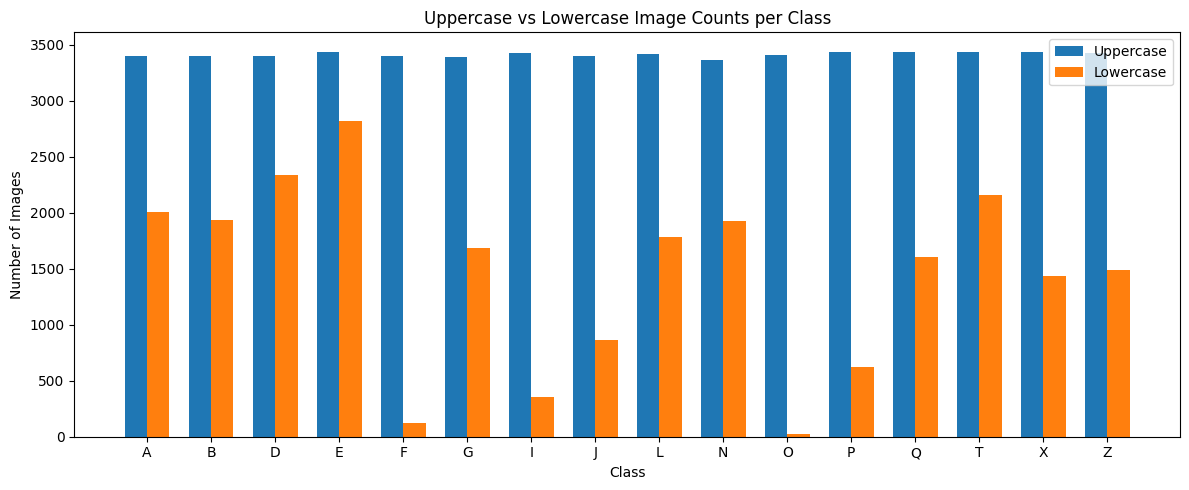

In [51]:
# Count number of images per class for uppercase and lowercase datasets

# For uppercase: use final_labels/final_images (labels 1-26, but only selected_numeric are present)
uppercase_counts = {}
for label in selected_numeric:
  uppercase_counts[chr(label + 64)] = np.sum(final_labels == label)

# For lowercase: use lowercase_labels/lowercase_images (labels 1-26)
lowercase_counts = {}
for label in selected_numeric:
  lowercase_counts[chr(label + 64)] = np.sum(lowercase_labels == label)

# Display comparison
print("Class | Uppercase | Lowercase")
print("------------------------------")
for letter in [chr(l + 64) for l in selected_numeric]:
  print(f"  {letter}   |   {uppercase_counts[letter]:7d} |   {lowercase_counts[letter]:7d}")

# Optionally, plot the comparison
labels_list = [chr(l + 64) for l in selected_numeric]
upper_vals = [uppercase_counts[l] for l in labels_list]
lower_vals = [lowercase_counts[l] for l in labels_list]

x = np.arange(len(labels_list))
width = 0.35

plt.figure(figsize=(12, 5))
plt.bar(x - width/2, upper_vals, width, label='Uppercase')
plt.bar(x + width/2, lower_vals, width, label='Lowercase')
plt.xticks(x, labels_list)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Uppercase vs Lowercase Image Counts per Class')
plt.legend()
plt.tight_layout()
plt.show()

In [54]:
# Only keep uppercase letters and remove mislabelled images

# Uppercase letters in EMNIST: labels 1-26 (A-Z), model output for uppercase is 0-25 (A-Z)
# We'll keep only samples where the model predicts an uppercase letter (0-25) and the ground truth is in 1-26

# Get mask for uppercase predictions
uppercase_pred_mask = (predicted_labels >= 0) & (predicted_labels <= 25)
# Get mask for valid ground truth labels (1-26)
valid_label_mask = (final_labels >= 1) & (final_labels <= 26)
# Map ground truth label to model's uppercase output (A=0, B=1, ..., Z=25)
mapped_ground_truth = final_labels - 1
correct_label_mask = predicted_labels == mapped_ground_truth

# Combine all masks
final_mask = uppercase_pred_mask & valid_label_mask & correct_label_mask

# Filter images and labels
uppercase_images = final_images[final_mask]
uppercase_labels = final_labels[final_mask]
uppercase_predicted_labels = predicted_labels[final_mask]

print(f"Kept {len(uppercase_images)} correctly labelled uppercase letter images.")


Kept 28873 correctly labelled uppercase letter images.


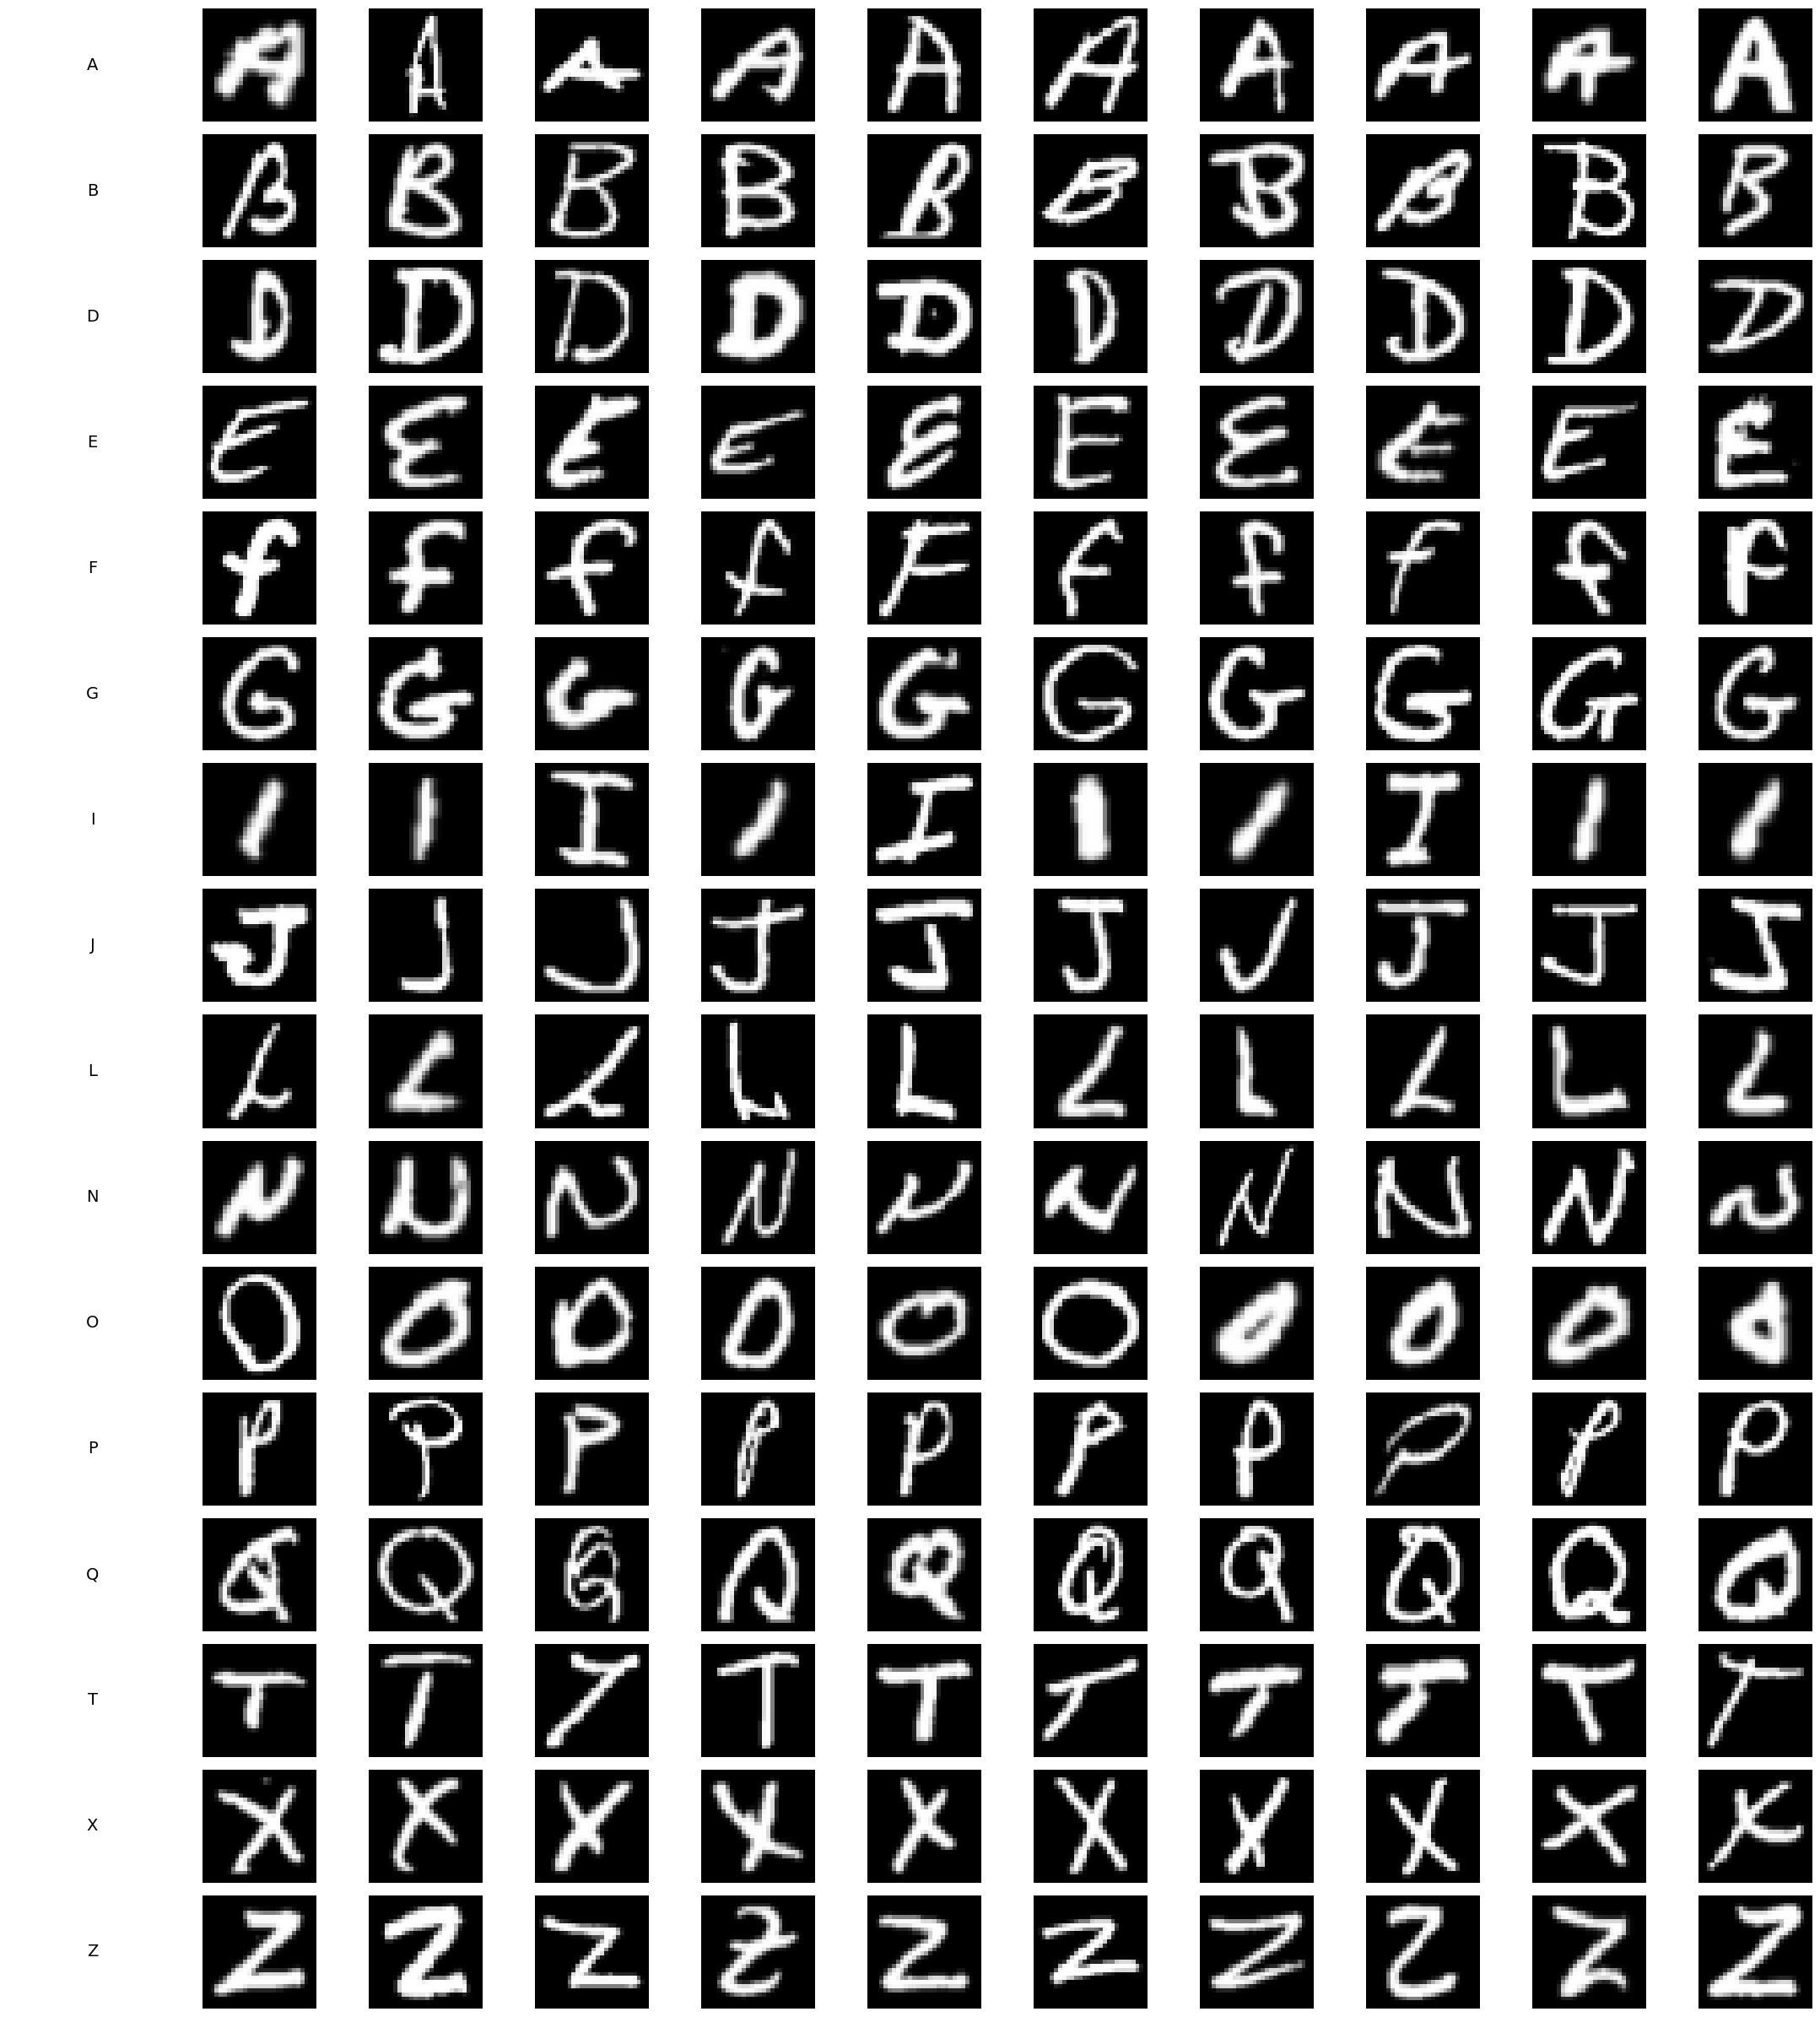

In [55]:
unique_labels_to_show = np.sort(np.unique(uppercase_labels))
num_classes = len(unique_labels_to_show)

cols = 11  # 1 for label + 10 for sample images
rows = num_classes  # Each class gets its own row

plt.figure(figsize=(cols * 2, rows * 1.5))

for idx, class_label in enumerate(unique_labels_to_show):
  class_indices = np.where(uppercase_labels == class_label)[0][:10]  # Get 10 samples

  # Label subplot
  plt.subplot(rows, cols, idx * cols + 1)
  plt.text(0.5, 0.5, f"{chr(class_label + 64)}", fontsize=14, ha='center', va='center')
  plt.axis('off')

  # Show 10 example images
  for i, img_idx in enumerate(class_indices):
    plt.subplot(rows, cols, idx * cols + i + 2)
    plt.imshow(uppercase_images[img_idx].squeeze(), cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()


# Create a Model to Train the Uppercase Dataset